<a href="https://colab.research.google.com/github/bhattacharjee/msc-ai-project/blob/main/iteration_3.0.ipynb/Autoencoder_iteration_3.3_invert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
auc_scores = {}
N_EPOCHS = 1
INVERT_TRAIN_TEST = False # If False, train with encrypted and test with non-encrypted

RANDOM_SEED = 42

In [101]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging, sys, random, glob
from google.colab import drive
from functools import lru_cache
import sklearn
from sklearn.model_selection import train_test_split

from tensorflow import keras as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import IPython

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


drive.mount("/content/drive")

def set_random_seed():
    np.random.seed(1)
    random.seed(1)
    tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

!if [[ -d /content/drive/MyDrive/MSCPROJDATA ]]; then cp -r /content/drive/MyDrive/MSCPROJDATA .; fi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))

    all_columns = [c for c in thisdf.columns]
    
    return {\
        "baseline": baseline_columns,\
        "advanced-only": advanced_columns_only,\
        "fourier-only": fourier_columns_only,\
        "baseline-and-fourier": baseline_and_fourier,\
        "advanced-and-fourier": advanced_and_fourier,\
        "advanced": advanced_columns,\
        "fourier": fourier_columns,\
        "all_columns": all_columns,
    }

# @lru_cache(maxsize=5)
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("MSCPROJDATA/**.parquet.gz", recursive=True):
        if not file.startswith("MSCPROJDATA/n1"):
            print(f"Loading {file}")
            df = pd.read_parquet(file)
            df = df.sample(frac=1).reset_index(drop=True)
            df["is_encrypted"] = 1 if "encr" in file.lower() else 0
            datasets[file] = df
    return datasets
    
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [103]:
temp_all_dfs = load_datasets_once()
temp_all_dfs['MSCPROJDATA/plaintext.base32.combined.parquet.gz'].columns

all_column_names = get_columns(temp_all_dfs['MSCPROJDATA/plaintext.base32.combined.parquet.gz'])
print(all_column_names.keys())
temp_all_dfs = None

import gc
def gc_collect():
    [gc.collect(i) for i in range(3) for j in range(3)]

gc_collect()

Loading MSCPROJDATA/plaintext.base32.combined.parquet.gz
Loading MSCPROJDATA/plaintext.expanded.parquet.gz
Loading MSCPROJDATA/expanded.plaintext.base32.parquet.gz
Loading MSCPROJDATA/plaintext.combined.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.b32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.base32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.parquet.gz
dict_keys(['baseline', 'advanced-only', 'fourier-only', 'baseline-and-fourier', 'advanced-and-fourier', 'advanced', 'fourier', 'all_columns'])


In [104]:
all_column_names.keys()

dict_keys(['baseline', 'advanced-only', 'fourier-only', 'baseline-and-fourier', 'advanced-and-fourier', 'advanced', 'fourier', 'all_columns'])

In [105]:
all_datasets = load_datasets_once()
full_dataset = pd.concat(all_datasets.values())
full_dataset = full_dataset.fillna(0.0)

if not INVERT_TRAIN_TEST:
    encrypted_df = full_dataset[full_dataset["is_encrypted"] == 1]
    non_encrypted_df = full_dataset[full_dataset["is_encrypted"] == 0]
else:
    encrypted_df = full_dataset[full_dataset["is_encrypted"] == 0]
    non_encrypted_df = full_dataset[full_dataset["is_encrypted"] == 1]

discard_some = True
if discard_some:
    retain = full_dataset['extended.base_filename'].map(lambda x: ".webp" not in x and "b32" not in x and "base32" not in x)
    full_dataset = full_dataset[retain]

# shuffle
encrypted_df = encrypted_df.sample(frac=1).reset_index(drop=True)
non_encrypted_df = non_encrypted_df.sample(frac=1).reset_index(drop=True)

columns = all_column_names["all_columns"]
print(f"Number of features in full dataset: {len(columns)}")

work_encrypted_df_X = encrypted_df[columns]
work_encrypted_df_y = encrypted_df["is_encrypted"]
work_non_encrypted_df_X = non_encrypted_df[columns]
work_non_encrypted_df_y = non_encrypted_df["is_encrypted"]


columns = []
for i, j in zip(work_encrypted_df_X.dtypes, work_encrypted_df_X.columns):
    if "float" in str(i):
        columns.append(j)

work_encrypted_df_X = work_encrypted_df_X[columns]
work_non_encrypted_df_X = work_non_encrypted_df_X[columns]

import gc
del all_datasets
del encrypted_df
del non_encrypted_df
for i in range(3):
    for j in range(3):
        gc.collect(j)
        gc.collect(i)

def normalize_df(X, Y):
    mindf = X.min()
    maxdf = X.max()
    print(mindf.shape)
    X = (X - mindf) / (maxdf - mindf)
    Y = (Y - mindf) / (maxdf - mindf)
    return X, Y

work_encrypted_df_X, work_non_encrypted_df_X = \
    normalize_df(
        work_encrypted_df_X,
        work_non_encrypted_df_X
    )

gc_collect()

Loading MSCPROJDATA/plaintext.base32.combined.parquet.gz
Loading MSCPROJDATA/plaintext.expanded.parquet.gz
Loading MSCPROJDATA/expanded.plaintext.base32.parquet.gz
Loading MSCPROJDATA/plaintext.combined.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.b32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.base32.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v1.parquet.gz
Loading MSCPROJDATA/expanded.pyencrypted_v2.parquet.gz
Number of features in full dataset: 676
(668,)


In [106]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(\
        work_encrypted_df_X,
        work_encrypted_df_y,
        test_size=0.33,
        random_state=42)

X_train.shape

(216686, 668)

In [107]:
def print_and_plot(model):
    print(model.summary())
    plot = tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        expand_nested=True)
    IPython.display.display(plot)


from sklearn.model_selection import train_test_split
def create_and_train_autoencoder(X, y, model, n_epochs):
    X_train, X_eval, y_train, y_eval= \
        train_test_split(X, y, test_size=0.2, random_state=42)

    nn = model
    nn.compile(optimizer='adam', loss='mse', metrics=["mae", "mse"])

    nn.build((None, X.shape[1]))
    print_and_plot(nn)

    print(X_train.shape, X_eval.shape)
    history = nn.fit(X_train, X_train,
                epochs=n_epochs,
                validation_data=(X_eval, X_eval),
                batch_size=32)
    return nn, history


def evaluate_model(model, columns:list, n_epochs:int, description:str):
    tf.random.set_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    c1 = set([c for c in work_encrypted_df_X.columns])
    c2 = set(columns)
    columns = c1.intersection(c2)
    print(f"Number of features: {len(columns)}")

    # Encrypted section, use half for training, we will use the remaining
    # half for testing
    temp_work_encrypted_df_X = work_encrypted_df_X[columns]
    temp_work_non_encrypted_df_X = work_non_encrypted_df_X[columns]

    nn = model

    columns = []
    for i, j in zip(temp_work_encrypted_df_X.dtypes, temp_work_encrypted_df_X.columns):
        if "float" in str(i):
            columns.append(j)
    temp_work_encrypted_df_X = temp_work_encrypted_df_X[columns]
    temp_work_non_encrypted_df_X = temp_work_non_encrypted_df_X[columns]

    eTrain_X, eTest_X, eTrain_y, eTest_y = \
        train_test_split(\
                        temp_work_encrypted_df_X,\
                        work_encrypted_df_y,\
                        test_size=0.2,\
                        random_state=42)

    nn, history = create_and_train_autoencoder(eTrain_X, eTrain_y, model, n_epochs)

    _, neTest_X, _, neTest_y = \
        train_test_split(\
                        temp_work_non_encrypted_df_X,\
                        work_non_encrypted_df_y,\
                        test_size=0.2,\
                        random_state=42)

    final_test_X = pd.concat([eTest_X, neTest_X])
    final_test_y = pd.concat([eTest_y, neTest_y])

    # ---------------------
    plt.rcParams["figure.figsize"] = (6, 3)
    
    for metric in ["loss", "mse", "mae"]:
        keys = []
        for k, v in history.history.items():
            if metric in k.lower():
                keys.append(k)
                plt.plot(v, label=k)
            plt.legend(keys)
        plt.show()

    # ----------------------------

    plt.rcParams["figure.figsize"] = (12, 6)
    def get_mse_mae(X, X1):
        saveX, saveX1 = X, X1
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        if not isinstance(X1, np.ndarray):
            X1 = X1.to_numpy()
        square_error = np.square(X - X1)
        mse = np.mean(square_error, axis=1)
        abs_error = np.square(X - X1)
        mae = np.mean(abs_error, axis=1)
        return mse, mae
    
    
    
    reconstructed_test_X = nn.predict(final_test_X)
    mse, mae = get_mse_mae(final_test_X, reconstructed_test_X)
    
    
    df_result = pd.DataFrame(\
        {\
            "is_encrypted": final_test_y,\
            "mse": mse,\
            "mae": mae,\
        }\
    )
    
    #df_result2 = df_result[df_result["mae"] < 0.1]
    df_result2 = df_result
    sns.stripplot(data=df_result2, x="is_encrypted", y="mse", jitter=0.5, size=0.7).set(title="Mean Square Error")
    plt.gca().set_yscale('log')
    plt.show()
    sns.boxplot(data=df_result2, x="is_encrypted", y="mse").set(title="Mean Square Error")
    
    plt.gca().set_yscale('log')
    plt.show()
    
    df = df_result
    df = df.sort_values(by="mse").reset_index()
    y_pred = np.log(df["mse"].to_numpy())
    y_true = df["is_encrypted"].to_numpy()
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_pred)
    auc_score = auc(fpr, tpr)
    print()
    print()
    plt.plot(fpr, tpr)
    print()
    print()
    print(f"AUC Score for {description} is : {auc_score}")

    return description, auc_score

Number of features: 668
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_383 (Dense)           (None, 668)               446892    
                                                                 
 dropout_153 (Dropout)       (None, 668)               0         
                                                                 
 dense_384 (Dense)           (None, 668)               446892    
                                                                 
 dropout_154 (Dropout)       (None, 668)               0         
                                                                 
 dense_385 (Dense)           (None, 512)               342528    
                                                                 
 dropout_155 (Dropout)       (None, 512)               0         
                                                                 
 dense_386 (Dense)           

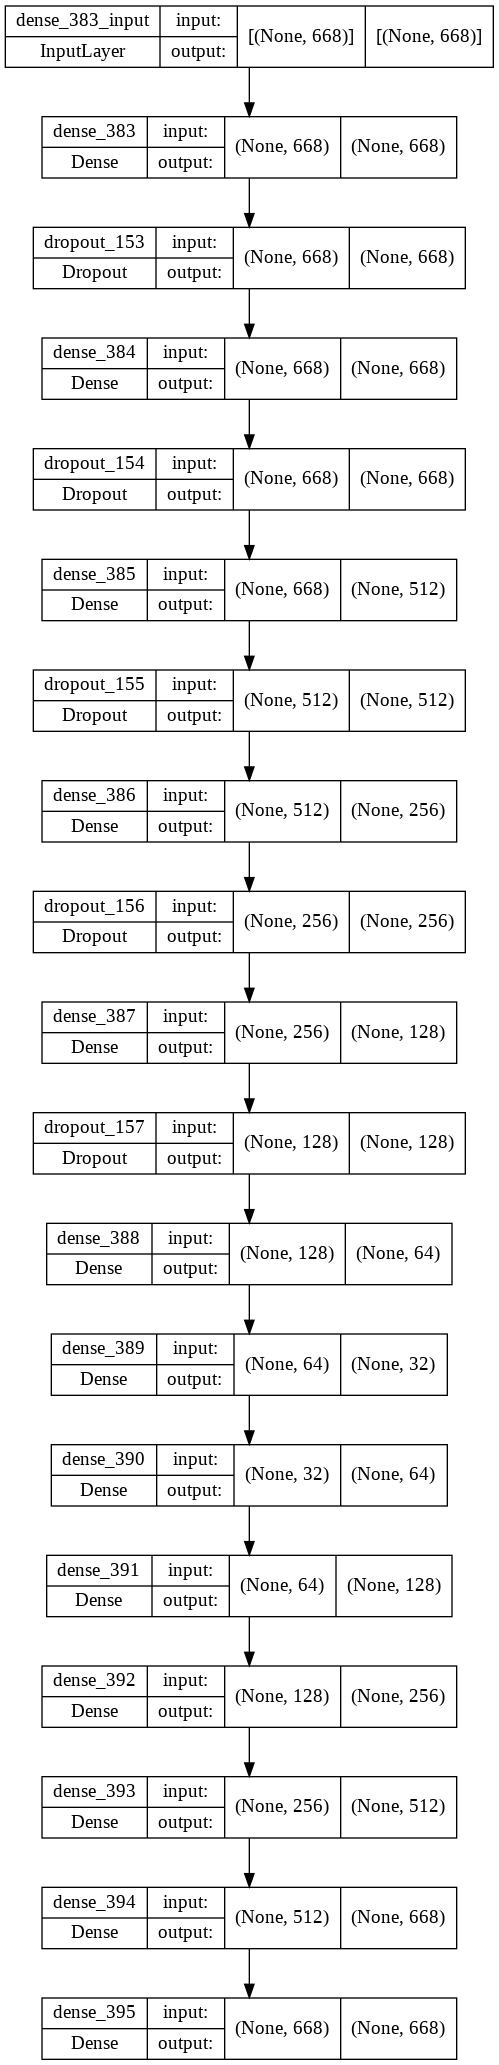

(206983, 668) (51746, 668)
6469/6469 [==============================] - 29s 4ms/step - loss: 0.0069 - mae: 0.0320 - mse: 0.0069 - val_loss: 0.0027 - val_mae: 0.0205 - val_mse: 0.0027


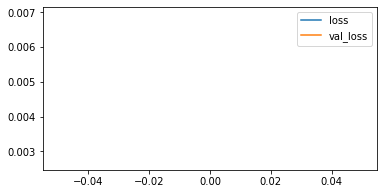

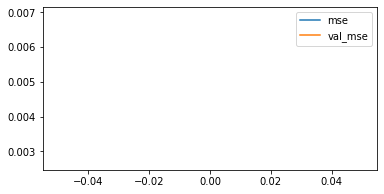

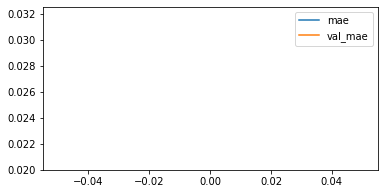

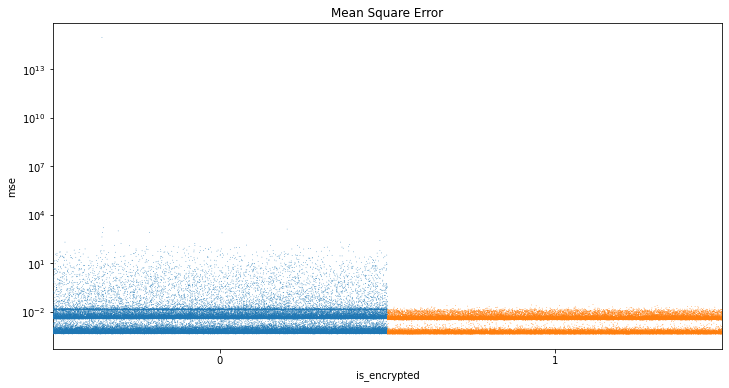

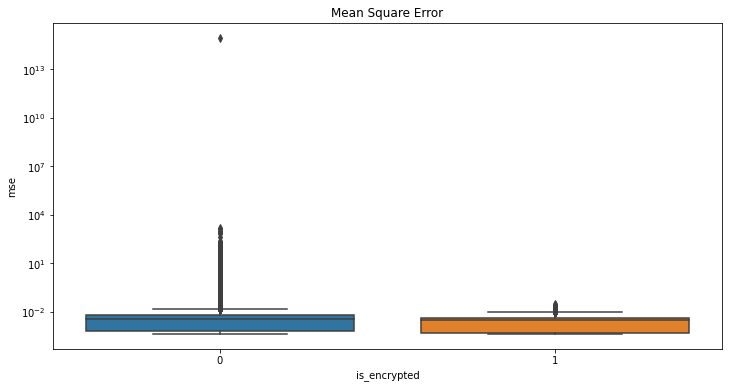





AUC Score for All columns is : 0.36033273145261807


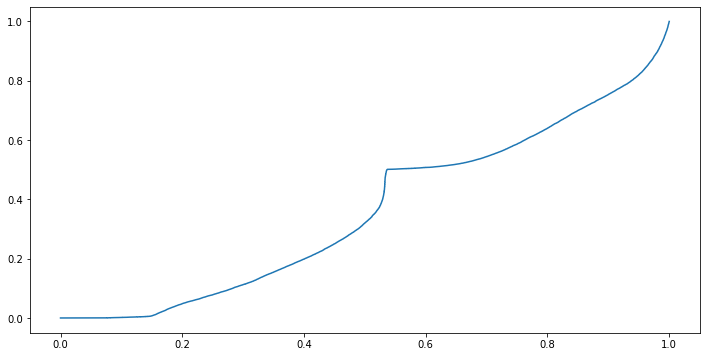

In [108]:
class Autoencoder_AllColumns:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(668, activation='relu'),
                layers.Dropout(0.25),
                layers.Dense(668, activation='relu'),
                layers.Dropout(0.25),
                layers.Dense(512, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(256, activation='relu'),
                layers.Dropout(0.1),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.05),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(512, activation='relu'),
                layers.Dense(668, activation='relu'),
                layers.Dense(668, activation='relu'),
            ]
        )
        return model


description, score = evaluate_model(Autoencoder_AllColumns.build(), all_column_names['all_columns'], N_EPOCHS, "All columns")
auc_scores[description] = score

Number of features: 4
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_396 (Dense)           (None, 4)                 20        
                                                                 
 dense_397 (Dense)           (None, 3)                 15        
                                                                 
 dense_398 (Dense)           (None, 2)                 8         
                                                                 
 dense_399 (Dense)           (None, 3)                 9         
                                                                 
 dense_400 (Dense)           (None, 4)                 16        
                                                                 
 dense_401 (Dense)           (None, 4)                 20        
                                                                 
Total params: 88
Trainable para

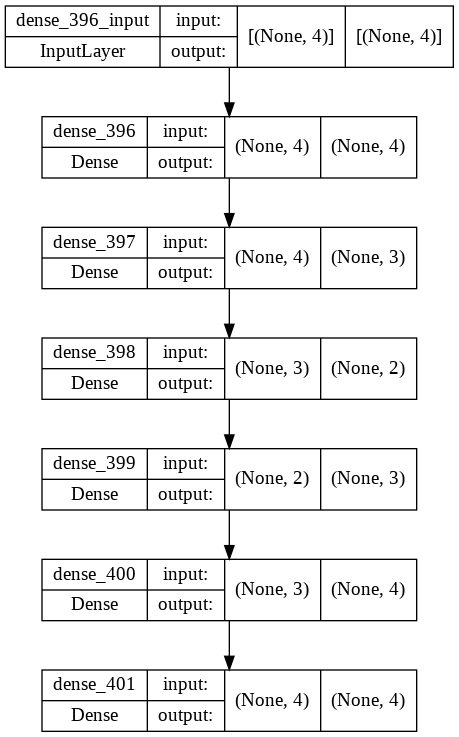

(206983, 4) (51746, 4)
6469/6469 [==============================] - 21s 3ms/step - loss: 0.0095 - mae: 0.0460 - mse: 0.0095 - val_loss: 0.0028 - val_mae: 0.0226 - val_mse: 0.0028


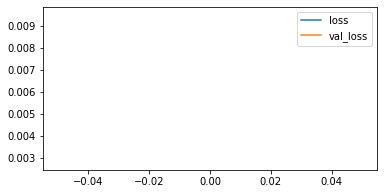

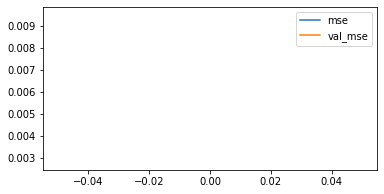

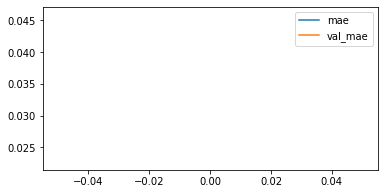

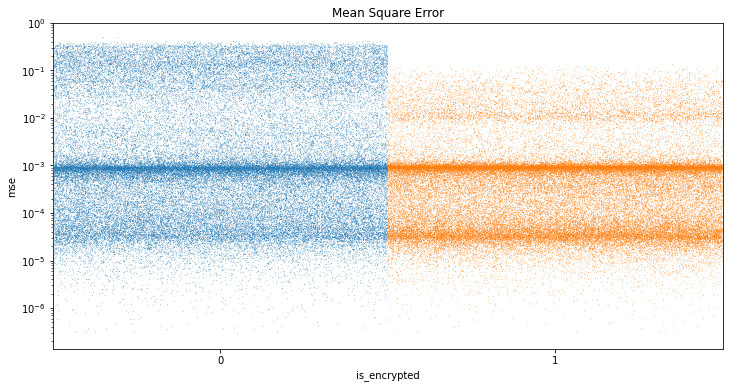

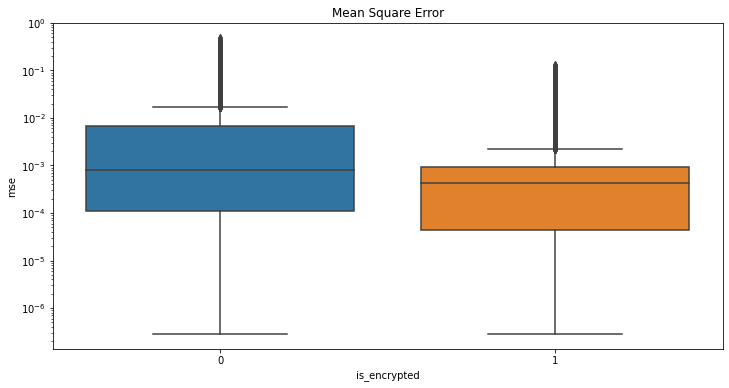





AUC Score for baseline is : 0.3816013012763155


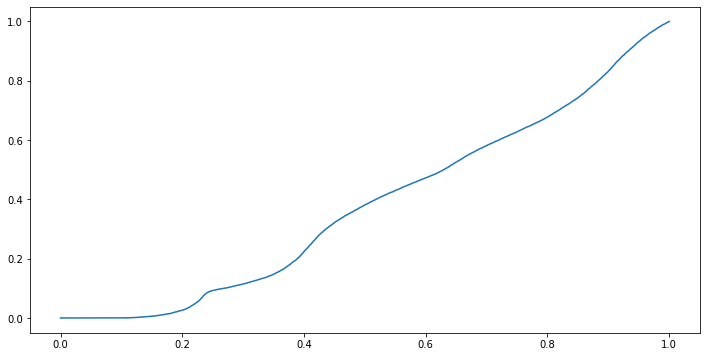

In [109]:
class Autoencoder_baseline:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(4, activation='relu'),
                layers.Dense(3, activation='relu'),
                layers.Dense(2, activation='relu'),
                layers.Dense(3, activation='relu'),
                layers.Dense(4, activation='relu'),
                layers.Dense(4, activation='sigmoid'),
            ]
        )
        return model


description, score = evaluate_model(Autoencoder_baseline.build(), all_column_names['baseline'], N_EPOCHS, "baseline")
auc_scores[description] = score

Number of features: 40
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_402 (Dense)           (None, 40)                1640      
                                                                 
 dropout_158 (Dropout)       (None, 40)                0         
                                                                 
 dense_403 (Dense)           (None, 30)                1230      
                                                                 
 dropout_159 (Dropout)       (None, 30)                0         
                                                                 
 dense_404 (Dense)           (None, 15)                465       
                                                                 
 dropout_160 (Dropout)       (None, 15)                0         
                                                                 
 dense_405 (Dense)           (

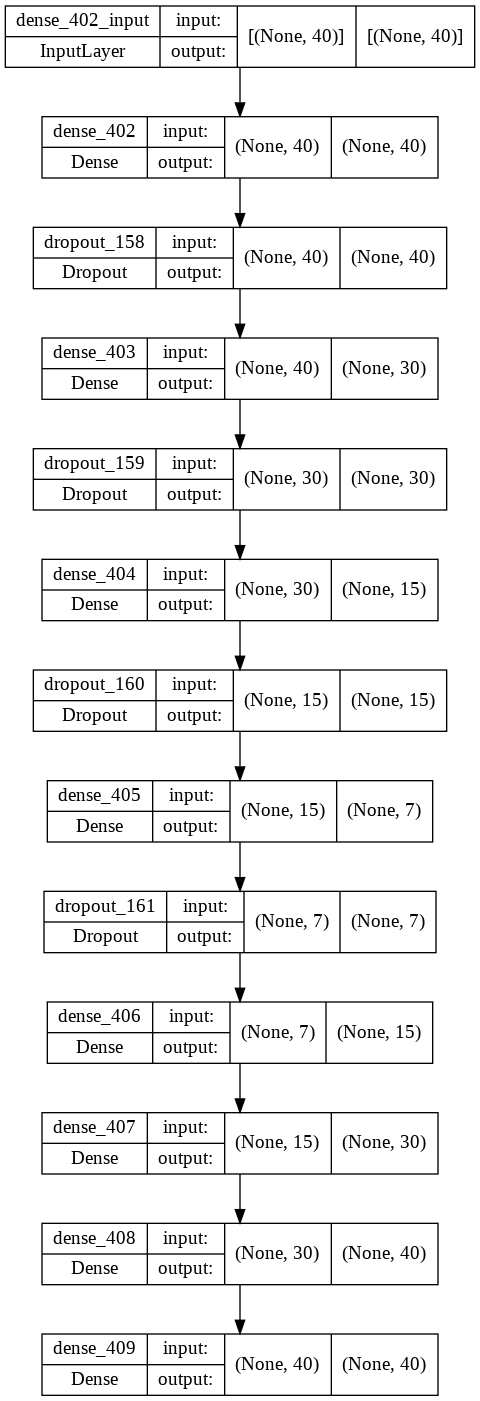

(206983, 40) (51746, 40)
6469/6469 [==============================] - 23s 4ms/step - loss: 0.0035 - mae: 0.0237 - mse: 0.0035 - val_loss: 8.7911e-04 - val_mae: 0.0144 - val_mse: 8.7911e-04


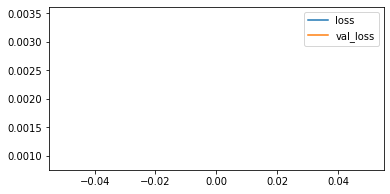

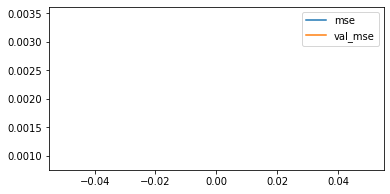

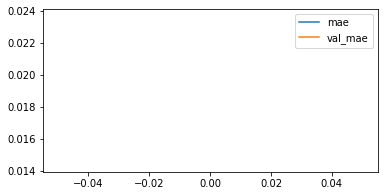

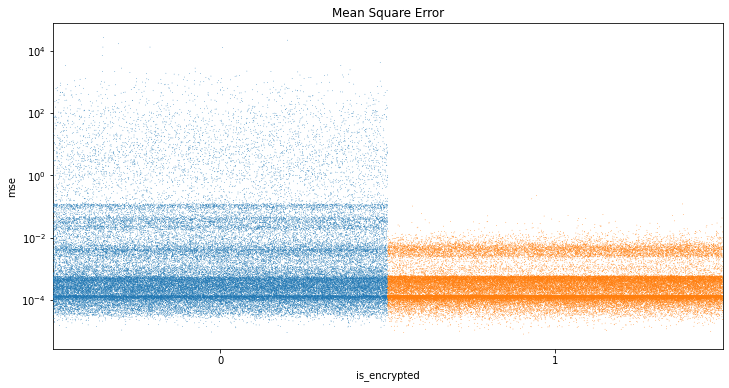

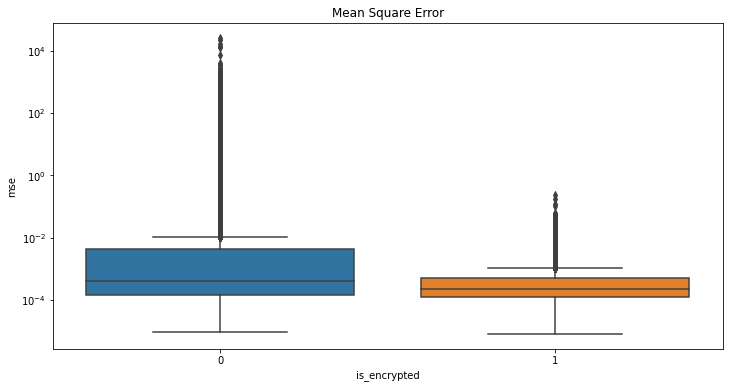





AUC Score for advanced-only is : 0.3718685649374796


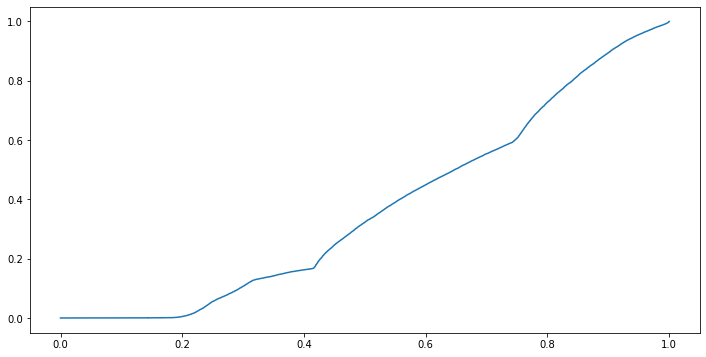

In [110]:
class Autoencoder_AdvancedOnly:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(40, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(30, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(7, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dense(30, activation='relu'),
                layers.Dense(40, activation='relu'),
                layers.Dense(40, activation='sigmoid'),
            ]
        )
        return model


gc_collect()
name = 'advanced-only'
description, score = evaluate_model(Autoencoder_AdvancedOnly.build(), all_column_names[name], N_EPOCHS, name)
auc_scores[description] = score

Number of features: 18
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_410 (Dense)           (None, 18)                342       
                                                                 
 dropout_162 (Dropout)       (None, 18)                0         
                                                                 
 dense_411 (Dense)           (None, 12)                228       
                                                                 
 dropout_163 (Dropout)       (None, 12)                0         
                                                                 
 dense_412 (Dense)           (None, 8)                 104       
                                                                 
 dropout_164 (Dropout)       (None, 8)                 0         
                                                                 
 dense_413 (Dense)           (

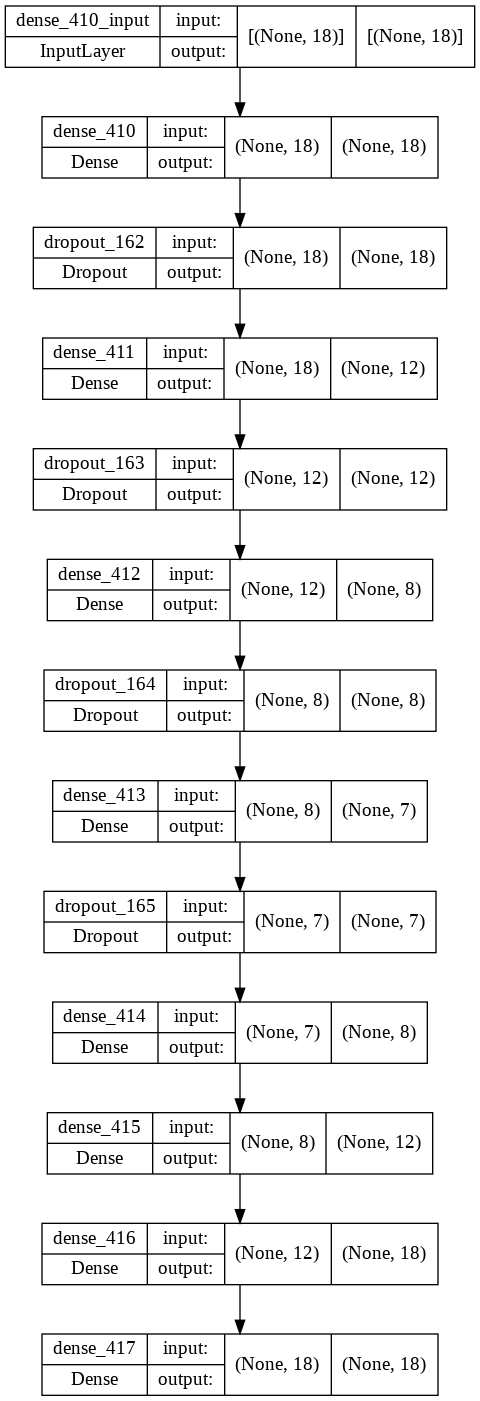

(206983, 18) (51746, 18)
6469/6469 [==============================] - 23s 3ms/step - loss: 0.0045 - mae: 0.0168 - mse: 0.0045 - val_loss: 4.2626e-04 - val_mae: 0.0055 - val_mse: 4.2626e-04


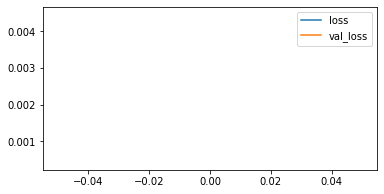

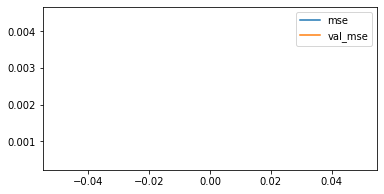

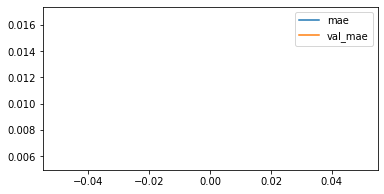

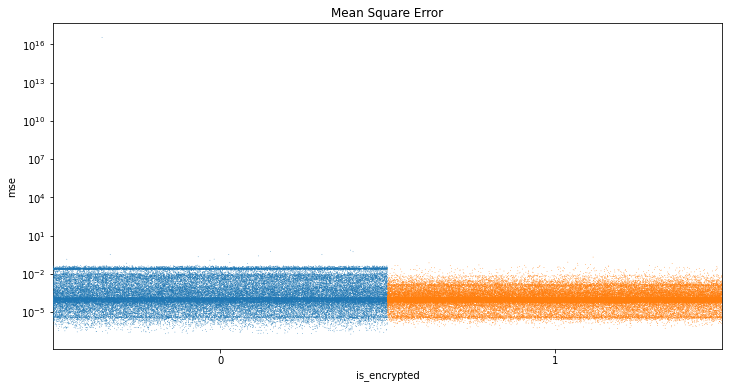

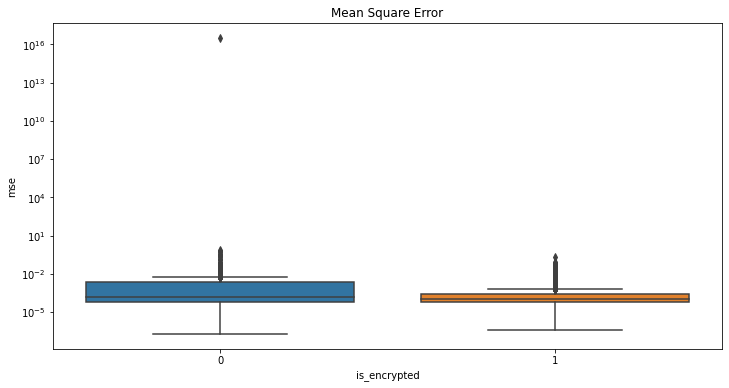





AUC Score for fourier-only is : 0.40440859421356623


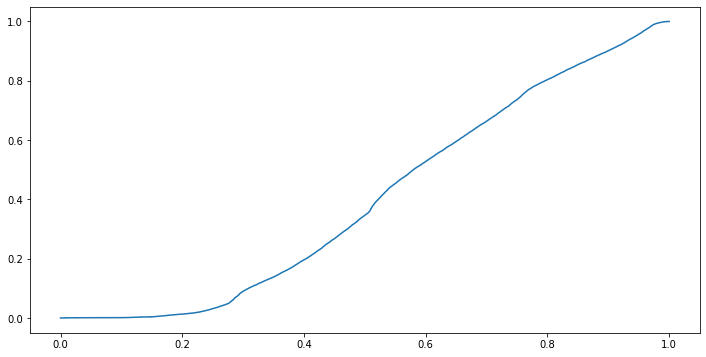

In [111]:
class Autoencoder_FourierOnly:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(18, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(12, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(8, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(7, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(8, activation='relu'),
                layers.Dense(12, activation='relu'),
                layers.Dense(18, activation='relu'),
                layers.Dense(18, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'fourier-only'
description, score = evaluate_model(Autoencoder_FourierOnly.build(), all_column_names[name], N_EPOCHS, name)
auc_scores[description] = score

In [112]:
gc_collect()

Number of features: 44
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_418 (Dense)           (None, 44)                1980      
                                                                 
 dropout_166 (Dropout)       (None, 44)                0         
                                                                 
 dense_419 (Dense)           (None, 40)                1800      
                                                                 
 dropout_167 (Dropout)       (None, 40)                0         
                                                                 
 dense_420 (Dense)           (None, 30)                1230      
                                                                 
 dropout_168 (Dropout)       (None, 30)                0         
                                                                 
 dense_421 (Dense)           (

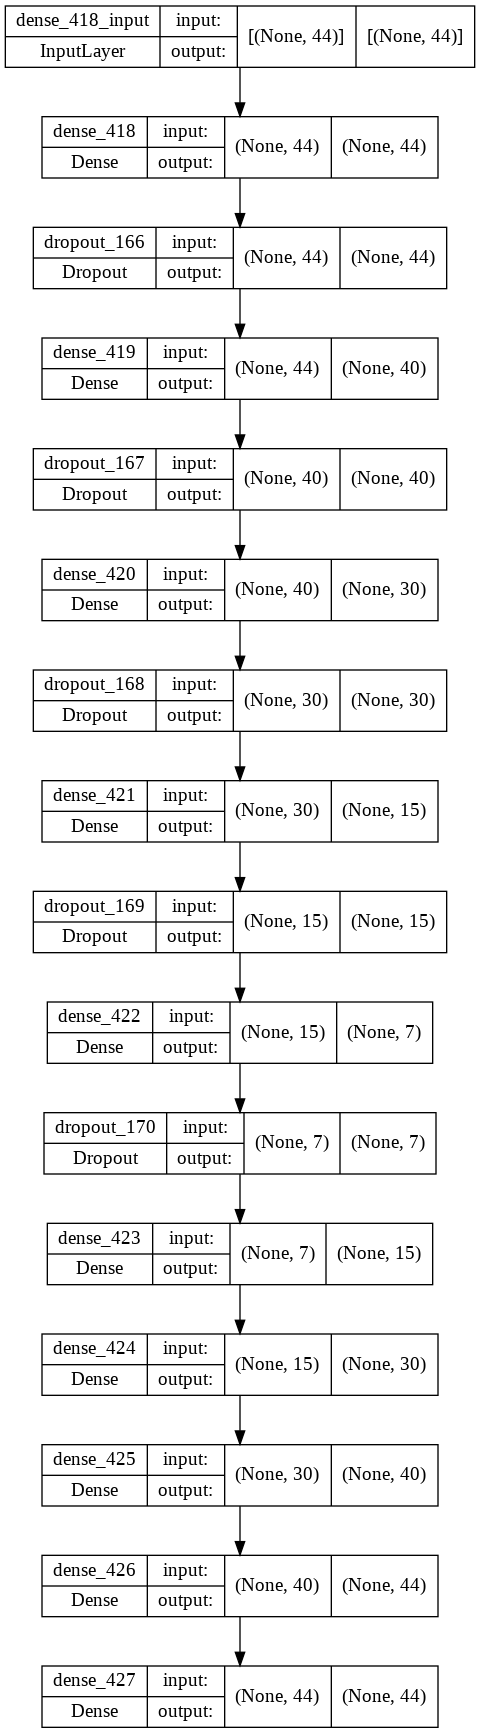

(206983, 44) (51746, 44)
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0034 - mae: 0.0237 - mse: 0.0034 - val_loss: 9.8440e-04 - val_mae: 0.0155 - val_mse: 9.8440e-04


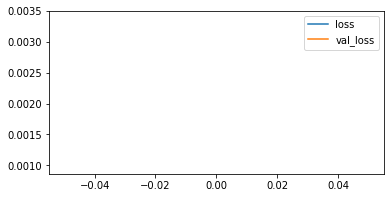

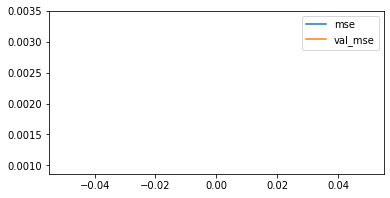

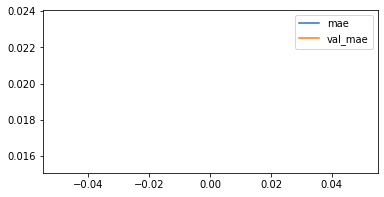

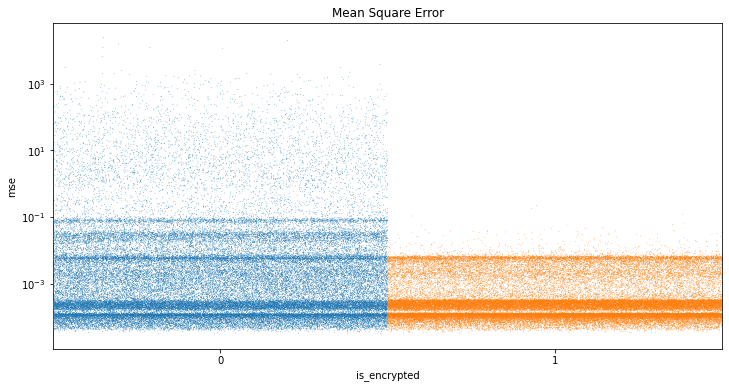

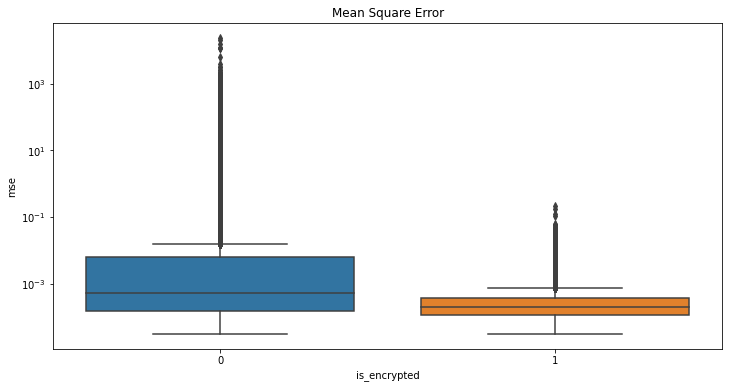





AUC Score for baseline-and-advanced is : 0.3471137743251769


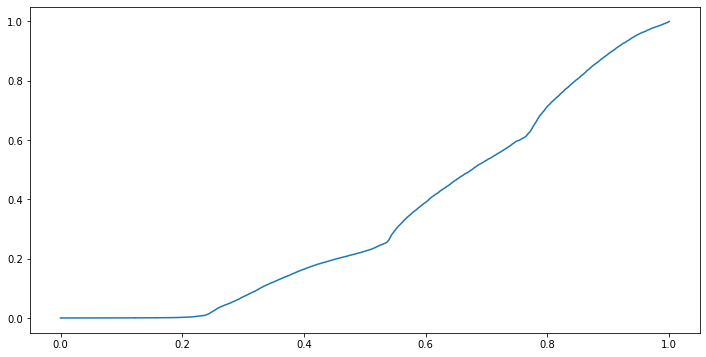

In [113]:
class Autoencoder_BaselineAndAdvanced:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(44, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(40, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(30, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(7, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dense(30, activation='relu'),
                layers.Dense(40, activation='relu'),
                layers.Dense(44, activation='relu'),
                layers.Dense(44, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'advanced'
description, score = evaluate_model(Autoencoder_BaselineAndAdvanced.build(), all_column_names[name], N_EPOCHS, "baseline-and-advanced")
auc_scores[description] = score

In [114]:
all_column_names.keys()

dict_keys(['baseline', 'advanced-only', 'fourier-only', 'baseline-and-fourier', 'advanced-and-fourier', 'advanced', 'fourier', 'all_columns'])

Number of features: 22
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_428 (Dense)           (None, 22)                506       
                                                                 
 dropout_171 (Dropout)       (None, 22)                0         
                                                                 
 dense_429 (Dense)           (None, 15)                345       
                                                                 
 dropout_172 (Dropout)       (None, 15)                0         
                                                                 
 dense_430 (Dense)           (None, 10)                160       
                                                                 
 dropout_173 (Dropout)       (None, 10)                0         
                                                                 
 dense_431 (Dense)           (

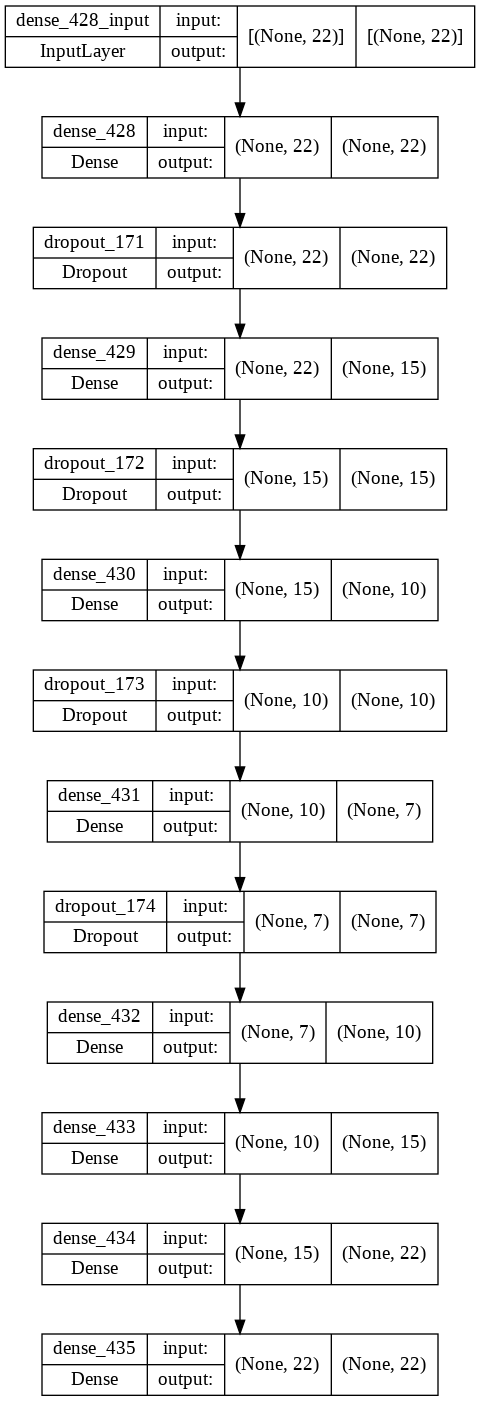

(206983, 22) (51746, 22)
6469/6469 [==============================] - 24s 4ms/step - loss: 0.0045 - mae: 0.0208 - mse: 0.0045 - val_loss: 6.8010e-04 - val_mae: 0.0089 - val_mse: 6.8010e-04


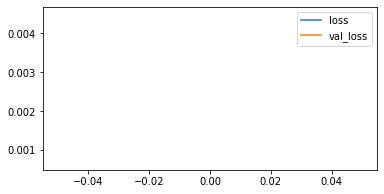

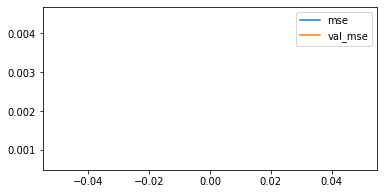

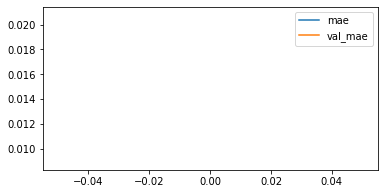

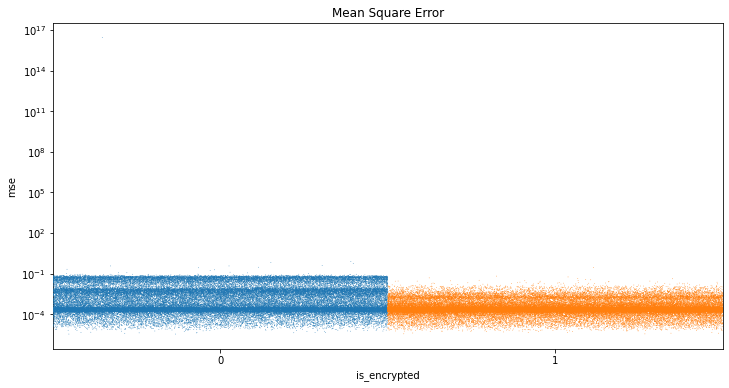

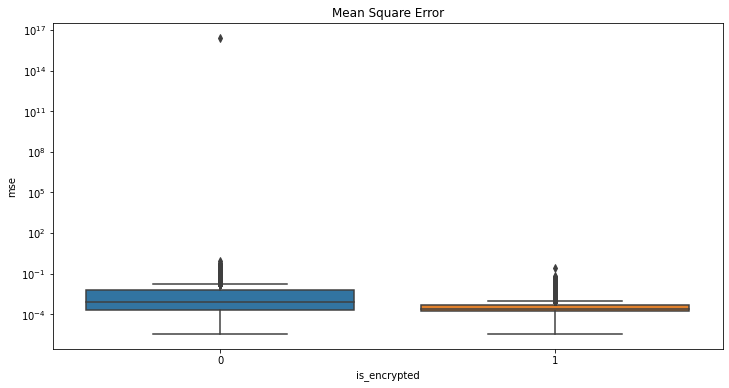





AUC Score for baseline-and-fourier is : 0.31427984992845254


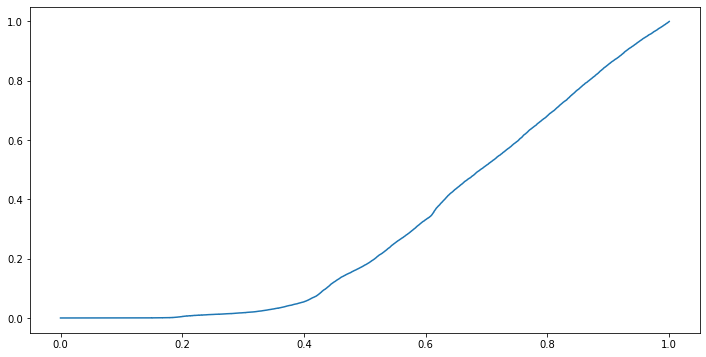

In [115]:
class Autoencoder_BaselineAndFourier:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(22, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(15, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(10, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(7, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(10, activation='relu'),
                layers.Dense(15, activation='relu'),
                layers.Dense(22, activation='relu'),
                layers.Dense(22, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'baseline-and-fourier'
description, score = evaluate_model(Autoencoder_BaselineAndFourier.build(), all_column_names[name], N_EPOCHS, name)
auc_scores[description] = score

Number of features: 58
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_436 (Dense)           (None, 58)                3422      
                                                                 
 dropout_175 (Dropout)       (None, 58)                0         
                                                                 
 dense_437 (Dense)           (None, 50)                2950      
                                                                 
 dropout_176 (Dropout)       (None, 50)                0         
                                                                 
 dense_438 (Dense)           (None, 25)                1275      
                                                                 
 dropout_177 (Dropout)       (None, 25)                0         
                                                                 
 dense_439 (Dense)           (

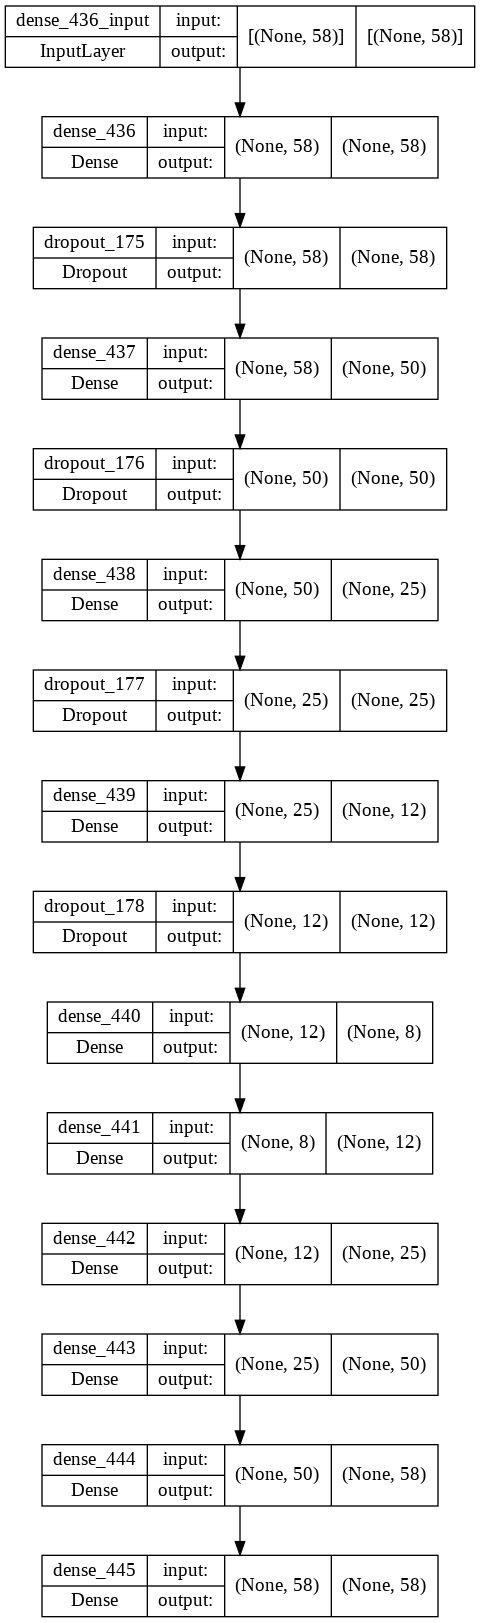

(206983, 58) (51746, 58)
6469/6469 [==============================] - 25s 4ms/step - loss: 0.0026 - mae: 0.0181 - mse: 0.0026 - val_loss: 5.5633e-04 - val_mae: 0.0102 - val_mse: 5.5633e-04


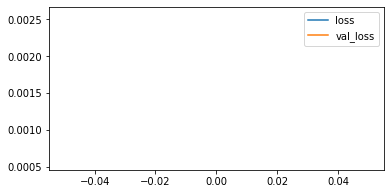

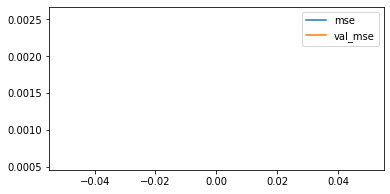

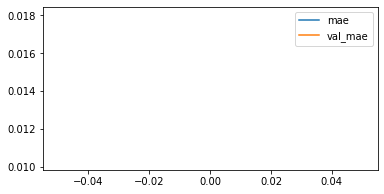

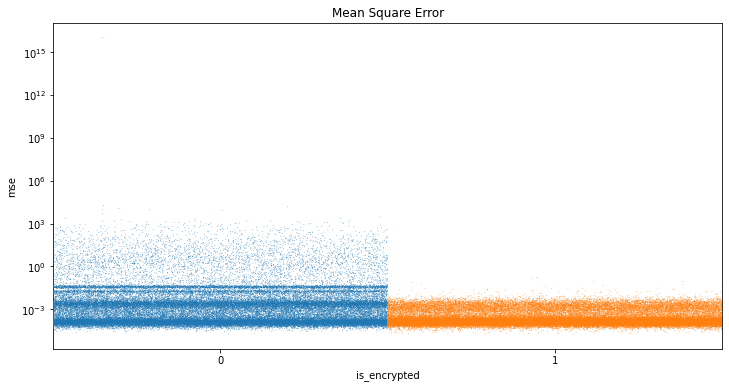

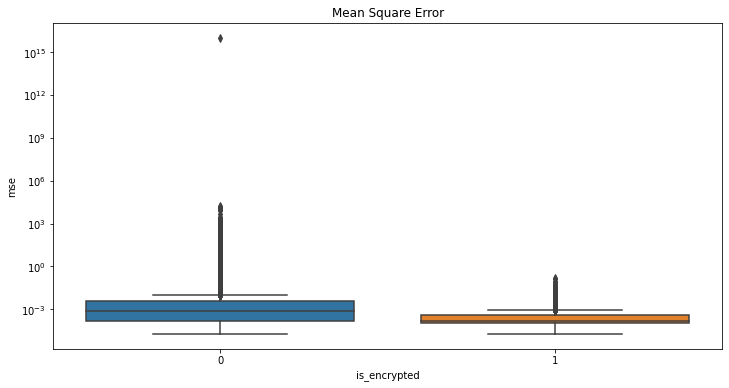





AUC Score for advanced-and-fourier is : 0.32267168023383697


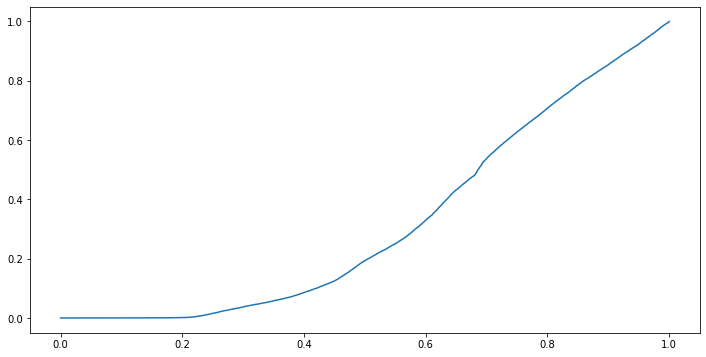

In [116]:
class Autoencoder_AdvancedAndFourier:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(58, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(50, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(25, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(12, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(8, activation='relu'),
                layers.Dense(12, activation='relu'),
                layers.Dense(25, activation='relu'),
                layers.Dense(50, activation='relu'),
                layers.Dense(58, activation='relu'),
                layers.Dense(58, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'advanced-and-fourier'
description, score = evaluate_model(Autoencoder_AdvancedAndFourier.build(), all_column_names[name], N_EPOCHS, name)
auc_scores[description] = score

Number of features: 62
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_446 (Dense)           (None, 62)                3906      
                                                                 
 dropout_179 (Dropout)       (None, 62)                0         
                                                                 
 dense_447 (Dense)           (None, 55)                3465      
                                                                 
 dropout_180 (Dropout)       (None, 55)                0         
                                                                 
 dense_448 (Dense)           (None, 50)                2800      
                                                                 
 dropout_181 (Dropout)       (None, 50)                0         
                                                                 
 dense_449 (Dense)           (

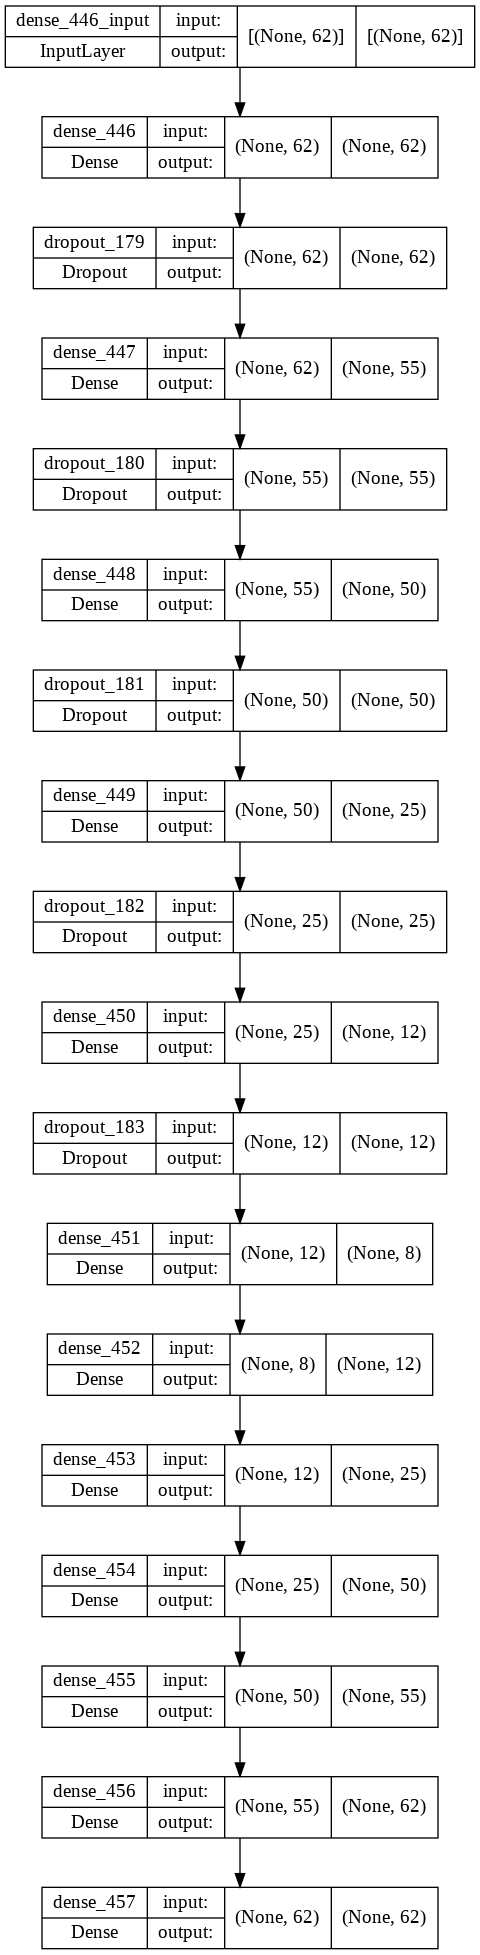

(206983, 62) (51746, 62)
6469/6469 [==============================] - 29s 4ms/step - loss: 0.0037 - mae: 0.0236 - mse: 0.0037 - val_loss: 8.1899e-04 - val_mae: 0.0132 - val_mse: 8.1899e-04


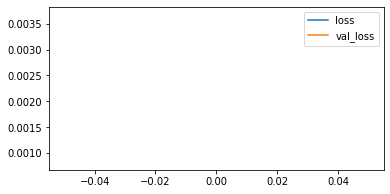

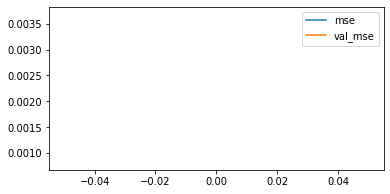

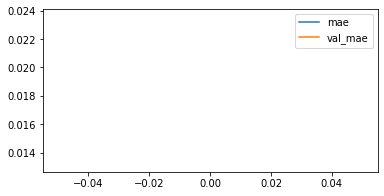

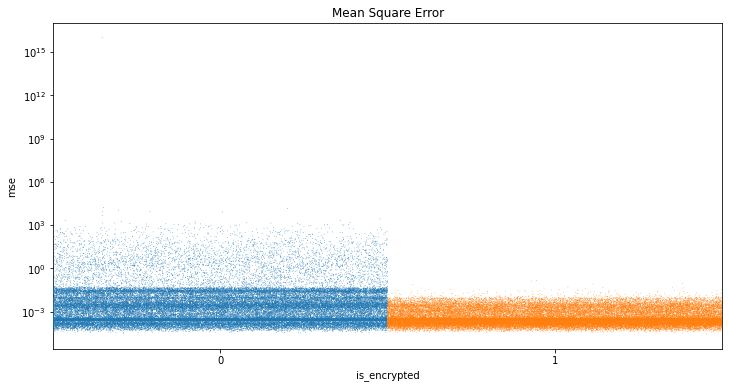

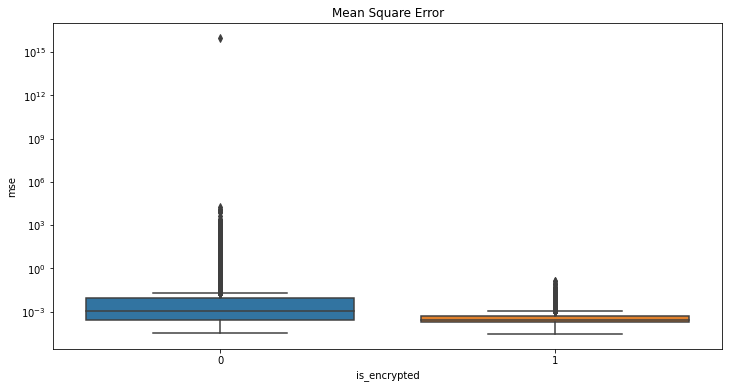





AUC Score for baseline-advanced-and-fourier is : 0.30761649603013785


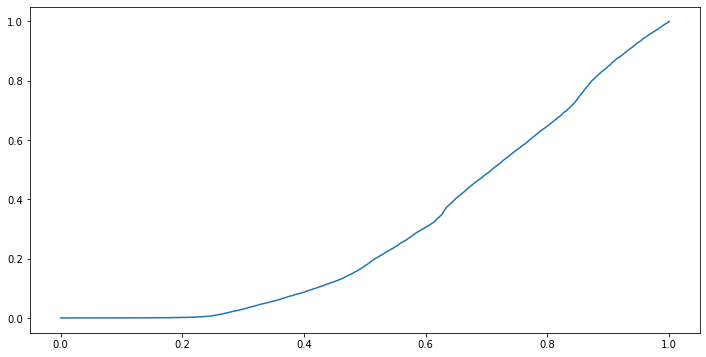

In [117]:
class Autoencoder_BaselineAdvancedAndFourier:
    @staticmethod
    def build():
        model = tf.keras.Sequential(
            [
                layers.Dense(62, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(55, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(50, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(25, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(12, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(8, activation='relu'),
                layers.Dense(12, activation='relu'),
                layers.Dense(25, activation='relu'),
                layers.Dense(50, activation='relu'),
                layers.Dense(55, activation='relu'),
                layers.Dense(62, activation='relu'),
                layers.Dense(62, activation='sigmoid'),
            ]
        )
        return model

gc_collect()
name = 'fourier'
description, score = evaluate_model(Autoencoder_BaselineAdvancedAndFourier.build(), all_column_names[name], N_EPOCHS, "baseline-advanced-and-fourier")
auc_scores[description] = score

In [118]:
print(auc_scores)

{'All columns': 0.36033273145261807, 'baseline': 0.3816013012763155, 'advanced-only': 0.3718685649374796, 'fourier-only': 0.40440859421356623, 'baseline-and-advanced': 0.3471137743251769, 'baseline-and-fourier': 0.31427984992845254, 'advanced-and-fourier': 0.32267168023383697, 'baseline-advanced-and-fourier': 0.30761649603013785}


In [119]:
for k, v in auc_scores.items():
    print(k, v)

All columns 0.36033273145261807
baseline 0.3816013012763155
advanced-only 0.3718685649374796
fourier-only 0.40440859421356623
baseline-and-advanced 0.3471137743251769
baseline-and-fourier 0.31427984992845254
advanced-and-fourier 0.32267168023383697
baseline-advanced-and-fourier 0.30761649603013785


In [120]:
keys = [k for k in auc_scores.keys()]
auc = [a for a in auc_scores.values()]

df = pd.DataFrame({"Feature Set": keys, "AUC": auc}).sort_values(by="AUC", ascending=False).reset_index(drop=True)
df

,Feature Set,AUC
0,fourier-only,0.404409
1,baseline,0.381601
2,advanced-only,0.371869
3,All columns,0.360333
4,baseline-and-advanced,0.347114
5,advanced-and-fourier,0.322672
6,baseline-and-fourier,0.314280
7,baseline-advanced-and-fourier,0.307616


In [121]:
print(df.to_latex())

\begin{tabular}{llr}
\toprule
{} &                    Feature Set &       AUC \\
\midrule
0 &                   fourier-only &  0.404409 \\
1 &                       baseline &  0.381601 \\
2 &                  advanced-only &  0.371869 \\
3 &                    All columns &  0.360333 \\
4 &          baseline-and-advanced &  0.347114 \\
5 &           advanced-and-fourier &  0.322672 \\
6 &           baseline-and-fourier &  0.314280 \\
7 &  baseline-advanced-and-fourier &  0.307616 \\
\bottomrule
\end{tabular}

